In [4]:
from mimic.utilities.utilities import set_all_seeds
from mimic.utilities.utilities import plot_gLV
from mimic.model_infer import *
from mimic.model_simulate import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import pandas as pd
import seaborn as sns


In [5]:
# some plotting functions
def plot_fit_gLV(yobs, y0, nsp, m_h, M_h):
    # plot the fit
    cols = ["red", "green", "blue", "royalblue", "black"]
    # cols = [1,2,3,4,5]
    yobs_pred = odeint(gLV, y0, times, args=(nsp, mu_h, M_h))
    for i in range(nsp):
        plt.plot(times, yobs[:, i], color=cols[i])
        plt.plot(times, yobs_pred[:, i], '--', color=cols[i])


def plot_params(mu_h, M_h, e_h):
    print("\ninferred params:")
    print("mu_hat/mu:")
    print(np.array(mu_h))
    print("\nM_hat/M:")
    print(np.round(np.array(M_h), decimals=2))
    print("e_hat/e:")
    print(np.array(e_h))

    # plot the params
    plt.figure(figsize=(6.4*3, 4.8))
    plt.subplot(1, 3, 1)
    plt.stem(np.arange(0, nsp, dtype="int32"), np.array(mu_h), markerfmt="D")

    plt.subplot(1, 3, 2)
    plt.stem(np.arange(0, nsp*nsp), np.array(M_h).flatten(), markerfmt="D")

    plt.subplot(1, 3, 3)
    plt.stem(np.arange(0, nsp), np.array(e_h), markerfmt="D")

## Repeat Stein et al. 2013 analysis
https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003388


minimum found: a0/a1/a2/error: 10.0 10.0 1e-06 1.4690699442465054
unconstrained error        : 1.6228149213798244

inferred params:
mu_hat/mu:
[0.25690182 0.65817874 0.31354597 0.4392043  0.25732104 0.21627062
 0.35990734 0.28629651 0.63850793 0.2180557  0.44677433]

M_hat/M:
[[-0.35  0.09 -0.22  0.04  0.14 -0.12  0.22  0.06 -0.23 -0.02 -0.08]
 [ 0.11 -0.58 -0.15 -0.   -0.08 -0.34  0.05 -0.02  0.31  0.06  0.  ]
 [-0.25 -0.11 -0.12  0.02  0.02 -0.3   0.24  0.03 -0.22 -0.01 -0.08]
 [-0.24  0.19 -0.06 -0.31 -0.03 -0.07  0.14 -0.02 -0.24 -0.02 -0.03]
 [-0.18 -0.14  0.01  0.03 -0.08 -0.28  0.2  -0.02 -0.23 -0.   -0.08]
 [-0.04  0.14 -0.07 -0.09 -0.11 -0.61 -0.16 -0.04  0.77  0.07  0.17]
 [-0.01 -0.09 -0.04  0.02 -0.03 -0.1  -0.04 -0.02 -0.16 -0.   -0.07]
 [-0.19 -0.13  0.05  0.02 -0.12 -0.29  0.21 -0.03 -0.42 -0.02 -0.08]
 [-0.25 -0.32 -0.06  0.15 -0.01 -0.34  0.32  0.01 -2.35 -0.13 -0.32]
 [-0.01 -0.21 -0.03  0.02 -0.    0.01  0.07  0.01 -1.13 -0.08 -0.1 ]
 [-0.38 -0.07  0.09  0.13  0.04 -

<Axes: >

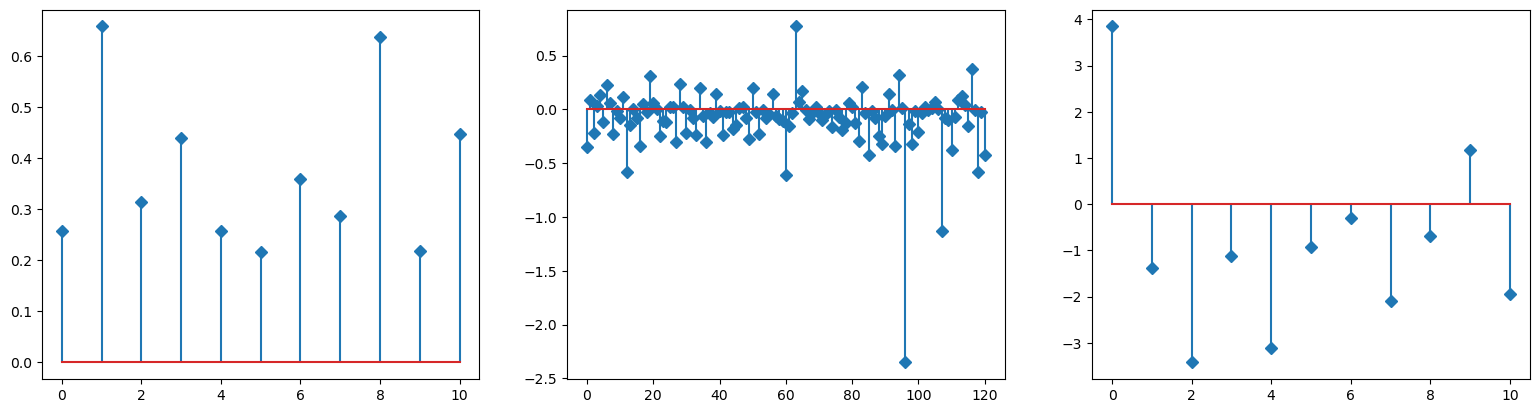

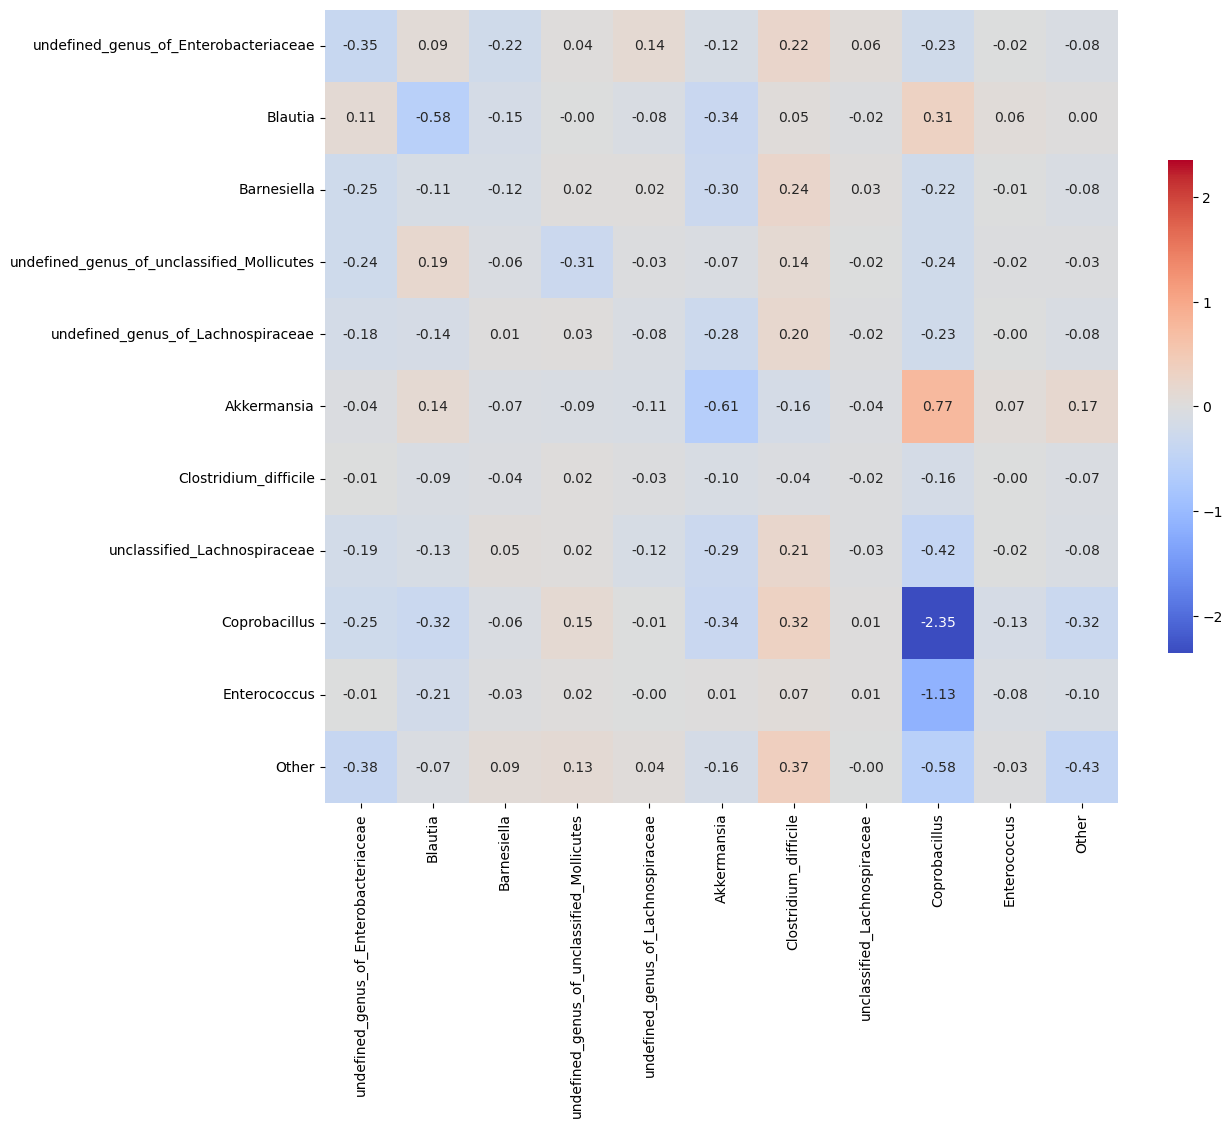

In [7]:
nsp = 11
npert = 1
# read in
F = pd.read_csv('Stein_example_F.csv', delimiter=',')
X = pd.read_csv('Stein_example_Y.csv', delimiter=',')

# print(F)
# print(X)

F = F.drop(F.columns[[0, 1]], axis=1)
X = X.drop(X.columns[[0, 1]], axis=1)

colnames = F.columns.to_list()

# print(F.shape)
# print(X.shape)

# get the best lambda/alpha values on a grid via cross validation
a0, a1, a2 = fit_alpha_Ridge2(X.to_numpy(), F.to_numpy(
), num_species=nsp, num_pert=npert, n_a0=10, n_a1=10, n_a2=10)

# do final fit
mu_h, M_h, e_h = do_final_fit_Ridge2(X.to_numpy(), F.to_numpy(
), num_species=nsp, num_pert=npert, a0=a0, a1=a1, a2=a2)

predictor = sim_gMLV(num_species=nsp,
                     num_metabolites=0,
                     M=M_h,
                     mu=mu_h,
                     epsilon=e_h)

plot_params(mu_h, M_h, e_h)

# plot interaction matrix
plt.figure(figsize=(6.4*2, 6.4*2))
lims = np.max([np.max(M_h), np.abs(np.min(M_h))])
sns.heatmap(M_h, xticklabels=colnames, yticklabels=colnames, square=True,
            vmin=-lims, vmax=lims, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": 0.5})